# Deployment Pipeline Overview

## 1. Download sample dataset

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os,sys,glob
from pathlib import Path
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'
sys.path.append('..')
from google.cloud import storage
from tqdm import tqdm
DATA_DIR='../input/deployment_data/DEMO0001'
# If True, download sample dataset
if os.path.exists(DATA_DIR):
    DOWNLOAD_FILES = False
else:
    DOWNLOAD_FILES = True


# If True, download pre-trained weights
if os.path.exists('../assets/weights/pretrained_weights/final_config'):
    DOWNLOAD_WEIGHTS = False
    WEIGHTS_PATH='../assets/weights/pretrained_weights/final_config'
else:
    DOWNLOAD_WEIGHTS = True

# # If you have your weights, change the DOWNLOAD_WEGHTS variable to True and insert the path to the weights:
# DOWNLOAD_WEIGHTS = False
# WEIGHTS_PATH='tour/path'

if DOWNLOAD_FILES:
    print("Downloading sample images...")
    
    # download dataset from Google Cloud
    storage_client = storage.Client.create_anonymous_client()
    bucket_name = "foca2023"
    parent_dir = "../input/"
    bucket = storage_client.bucket(bucket_name)
    blobs=bucket.list_blobs()
    blobs = [blob for blob in blobs if blob.name.startswith('deployment_data') and blob.name.endswith('.tiff')]
    pbar = tqdm(blobs)
    for blob in pbar:
        pbar.set_description("/".join(blob.name.split('/')[:2]))
        blob = bucket.blob(blob.name)
        blob_path =  "/".join(blob.name.split('/')[:-1])
        if not os.path.isdir(os.path.join(parent_dir,blob_path)):
            path = Path(os.path.join(parent_dir,blob_path))
            path.mkdir(parents=True)
        blob.download_to_filename(os.path.join(parent_dir,blob.name))
else: 
    print('Images found in folder')


Images found in folder


## 2. Construct dataset

In [111]:
from deployment.dataloader import DeploymentDataGenerator,load_config

test_imgs = sorted(glob.glob(DATA_DIR+'/**/*.tiff',recursive=True))#[f for f in os.listdir(DATA_DIR) if f.endswith(('.tiff','.jpg'))])


# Dataframe construction
df = pd.DataFrame(columns=['Location','Filename','Well'])
df['Filename'] = [f[f.rindex('/')+1:] for f in test_imgs]
wells = [f.split('_')[1] for f in df['Filename']]
rows = [w[0] for w in wells]
cols = [w[1:].zfill(2) for w in wells]
wells = [r+c for r,c in zip(rows,cols)]
df['Well'] = wells
df['Location'] = [f[:f.rindex('/')+1] for f in test_imgs]
df['Plate']= [f[f.find('PLATE')+10:f.find('PLATE')+13] for f in test_imgs]
df.sort_values(by='Well',inplace=True,ignore_index=True)

# Datagenerator for loading and patch-ifying wells
default_config = load_config('../input/default.yaml')
datagen = DeploymentDataGenerator(df,**default_config)
with pd.option_context('expand_frame_repr', False):
    print(df.head())

                                            Location              Filename Well Plate
0  ../input/deployment_data/DEMO0001/DEMO0001_PLA...  Well_A1_Ch2_4um.tiff  A01   002
1  ../input/deployment_data/DEMO0001/DEMO0001_PLA...  Well_A1_Ch2_4um.tiff  A01   001
2  ../input/deployment_data/DEMO0001/DEMO0001_PLA...  Well_A2_Ch2_4um.tiff  A02   002
3  ../input/deployment_data/DEMO0001/DEMO0001_PLA...  Well_A2_Ch2_4um.tiff  A02   001
4  ../input/deployment_data/DEMO0001/DEMO0001_PLA...  Well_A3_Ch2_4um.tiff  A03   001


## 3. Load model

In [78]:
from models.foca import FocA
if DOWNLOAD_WEIGHTS:
    print('Downloading pretrained weights...')
    
    # download weights from Google Cloud
    parent_dir = '../assets/weights/'
    storage_client = storage.Client.create_anonymous_client()
    bucket_name = "foca2023"
    bucket = storage_client.bucket(bucket_name)
    blobs=bucket.list_blobs()
    blobs = [blob for blob in blobs if blob.name.startswith('pretrained_weights') and not blob.name.endswith('/')]

    pbar = tqdm(blobs)
    for blob in pbar:
        pbar.set_description("/".join(blob.name.split('/')[:2]))
        blob = bucket.blob(blob.name)
        blob_path =  "/".join(blob.name.split('/')[:-1])
        if not os.path.isdir(os.path.join(parent_dir,blob_path)):
            path = Path(os.path.join(parent_dir,blob_path))
            path.mkdir(parents=True)
        blob.download_to_filename(os.path.join(parent_dir,blob.name))
    WEIGHTS_PATH = os.path.join(parent_dir,"pretrained_weights/final_config")
    
else:
    # if desired, choose your own weights
    WEIGHTS_PATH = WEIGHTS_PATH
    
foca = FocA(weights=WEIGHTS_PATH)
foca.model.summary()

Model: "foca"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 100, 100, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 50, 50, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 50, 50, 64)        51264     
                                                                 
 pool2 (MaxPooling2D)        (None, 25, 25, 64)        0         
                                                                 
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 fc3 (Dense)                 (None, 512)               20480512  
                                                                 
 dropout3 (Dropout)          (None, 512)               0      

## 4. Evaluate patch-level focus

48/48 [==============================] - 1s 21ms/step


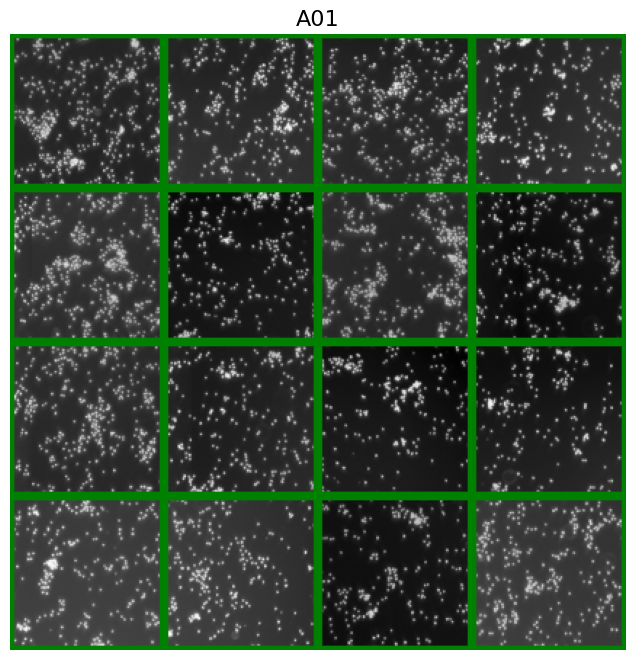

In [84]:
import tensorflow as tf
from colour import Color
import cv2 as cv
def round_nearest(x,a):
    return round(x / a) * a
def image_grid(array, scores,ncols=4,sort=False,with_color=True,border_padding=3):
    '''
    Create grid of patches sorted with colored borders according to their
    focal level scores

    Args:
        array: np.ndarray
            3D array of patches (num_patches,dim,dim)

        scores: np.ndarray
            scores for each patch for the desired class
            1 == in class
            0 == not in class

        ncols: int
            number of columns in grid
        
        sort: bool
            sort patches by score in descending order
        
        with_color: bool
            if True, draw colored borders by score and confidence
            if False, draw white borders
        
        border_padding: int
            thickness of border for each patch on grid (in pixels)

    Returns:
        img_grid: np.ndarray
            grid of patches with colored borders

    '''

    ######## FOR JEFF: it is not too intuitive how to plot the second plate in my opinion. I did add the plate info in the dataframe. Would it be too difficult to  implement a plate selection? 
    ## (or if easier just plot the second plate too, so people can see how to do it properly)
    array = tf.constant(np.expand_dims(array,axis=-1))
    array = tf.image.grayscale_to_rgb(array).numpy()
    confidence = np.absolute(scores-0.5)*2

    red = Color("green")
    colors = list(red.range_to(Color("red"),101))
    npad = ((0,0),(border_padding,border_padding),(border_padding,border_padding),(0,0))
    array_with_borders = np.zeros((array.shape[0],array.shape[1]+npad[1][0]+npad[1][1],array.shape[2]+npad[2][0]+npad[2][1],array.shape[3]))
    for i in range(len(array)):
        c_id = int(round_nearest(np.round(scores[i]),0.01)*100)
        if c_id < 0 or c_id > 100 :
            print(c_id)
        color = colors[c_id].rgb

        color = tuple(np.array(list(color))*confidence[i])
        if not with_color:
            color = (1,1,1)
    #         print(color)
        array_with_borders[i] = cv.copyMakeBorder(array[i],npad[1][0],npad[1][1],npad[2][0],npad[2][1],borderType=cv.BORDER_CONSTANT,value=color)
    if sort:
        sort_indices = np.argsort(scores)[::-1]
        array_with_borders= array_with_borders[sort_indices]
        scores = scores[sort_indices]

    array = array_with_borders
    padding = len(array)%ncols

    if padding > 0:
        array = np.concatenate((array,np.zeros((padding,array.shape[1],array.shape[2],3))),axis=0)
    (index, height, width, channels) = array.shape

    nrows = index//ncols

    img_grid = (array.reshape(nrows, ncols, height, width,channels)
        .swapaxes(1,2)
        .reshape(height*nrows, width*ncols,channels))
    return img_grid

patches = datagen[0]
labels = foca.model.predict(patches)
score_viz = image_grid(patches[:16,:,:,0],labels.squeeze())

plt.figure(figsize=(8,8))
plt.title(datagen.current_batch.loc[0,'Well'],size=16)
plt.imshow(score_viz)
plt.axis('off')
plt.show()

## 5. Evaluate well-level focus

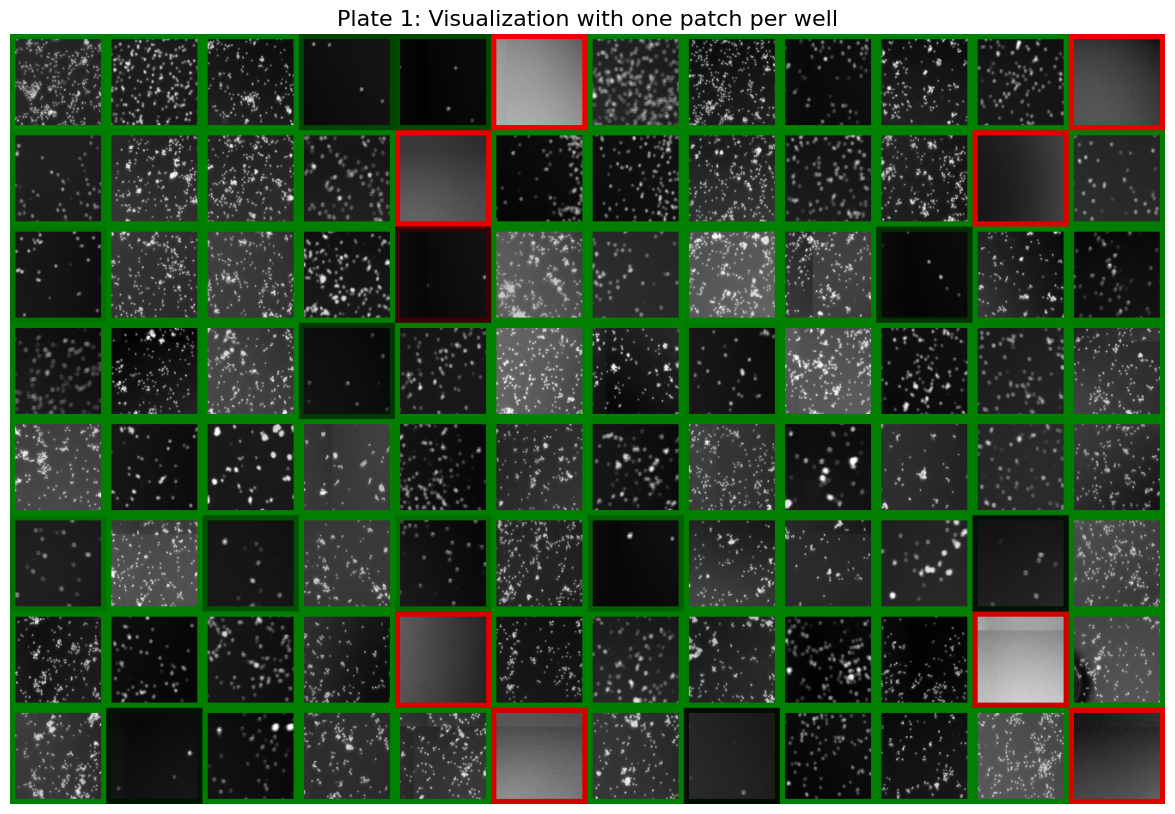

In [141]:
import string
PATCHES_PER_WELL = 16
confidences = np.abs(labels-0.5)*2

well_scores = np.zeros(96)
for i in range(round(len(labels)/PATCHES_PER_WELL)):
    # confidence weighting
    well_confidences = confidences[i*16:(i+1)*16]
    norm_confidences = well_confidences/(np.sum(well_confidences))
    well_score = np.sum(labels[i*16:(i+1)*16]*norm_confidences)
    well_scores[i] = well_score

plate_map = image_grid(patches[0::16,:,:,0],well_scores,ncols=12,border_padding=6)

plt.figure(figsize=(15,10))
plt.title('Plate 1: Visualization with one patch per well',size=16)
plt.imshow(plate_map)
plt.axis('off')
plt.show()

In [122]:
96*2

192

## 6. Organize output

In [86]:
from datetime import datetime
output_df = pd.DataFrame(columns=['Run','Plate','ANALYSIS_TIME','SCAN_TIME','IS_OOF','IF_COUNT','OOF_COUNT','EMPTY_COUNT','OOF_WELLS'])
output_df[['Run','Plate','ANALYSIS_TIME']]=[['DEMO','001',datetime.now()]]

well_labels = np.where(well_scores>0.5,1,0)
OOF_count = np.count_nonzero(well_labels)
IF_count = len(well_labels)-OOF_count
empty_count = 0
OOF_wells = ','.join(datagen.current_batch['Well'].iloc[np.argwhere(well_labels==1).flatten()].tolist())
output_df[['IS_OOF','IF_COUNT','OOF_COUNT','EMPTY_COUNT','OOF_WELLS']] = [[1 if OOF_count > 0 else 0,IF_count,OOF_count,empty_count,OOF_wells]]

with pd.option_context('expand_frame_repr', False):
    print(output_df)

    Run Plate              ANALYSIS_TIME SCAN_TIME IS_OOF IF_COUNT OOF_COUNT EMPTY_COUNT                            OOF_WELLS
0  DEMO   001 2023-06-21 15:19:24.023074       NaN      1       87         9           0  A03,A06,A09,A12,B03,D03,D06,D09,D12
